In [2]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn, optim
import wandb

C:\Users\HANNI\anaconda3\envs\link_dl\Lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
C:\Users\HANNI\anaconda3\envs\link_dl\Lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotat

In [3]:
class TitanicDataset(Dataset): ## Make_Data_Ready Titanic_Dataset
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        feature = self.X[idx]
        target = self.y[idx]
        return {'input': feature, 'target': target}

    def __str__(self):
        str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
            len(self.X), self.X.shape, self.y.shape
        )
        return str

In [4]:
class TitanicTestDataset(Dataset): ## Make_Data_Ready Titanic_Test_Dataset
    def __init__(self, X):
        self.X = torch.FloatTensor(X)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        feature = self.X[idx]
        return {'input' : feature}

    def __str__(self):
        str = "Data Size: {0}, Input Shape : {1}".format(
            len(self.X), self.X.shape
        )
        return str

In [5]:
def get_preprocessed_dataset():
    CURRENT_FILE_PATH = os.path.dirname(os.getcwd())

    train_data_path = os.path.join(CURRENT_FILE_PATH,"_04_your_code", "train.csv")
    test_data_path = os.path.join(CURRENT_FILE_PATH, "_04_your_code", "test.csv")

    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(test_data_path)

    all_df = pd.concat([train_df, test_df], sort=False)

    all_df = get_preprocessed_dataset_1(all_df)

    all_df = get_preprocessed_dataset_2(all_df)

    all_df = get_preprocessed_dataset_3(all_df)

    all_df = get_preprocessed_dataset_4(all_df)

    all_df = get_preprocessed_dataset_5(all_df)

    all_df = get_preprocessed_dataset_6(all_df)

    train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
    train_y = train_df["Survived"]

    test_X = all_df[all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)

    dataset = TitanicDataset(train_X.values, train_y.values)
    ##print(dataset)
    train_dataset, validation_dataset = random_split(dataset, [0.8, 0.2])
    test_dataset = TitanicTestDataset(test_X.values)
    ##print(test_dataset)
    print("train_X shape:", train_X.shape)
    print("feature columns:", list(train_X.columns))
    print("feature count:", len(train_X.columns))
    
    return train_dataset, validation_dataset, test_dataset

In [6]:
def get_preprocessed_dataset_1(all_df):
    # Pclass별 Fare 평균값을 사용하여 Fare 결측치 메우기
    Fare_mean = all_df[["Pclass", "Fare"]].groupby("Pclass").mean().reset_index()
    Fare_mean.columns = ["Pclass", "Fare_mean"]
    all_df = pd.merge(all_df, Fare_mean, on="Pclass", how="left")
    all_df.loc[(all_df["Fare"].isnull()), "Fare"] = all_df["Fare_mean"]
    all_df = all_df.drop(["Fare_mean"], axis=1) # Fare_mean Feature를 제외함 제외전 11개 제외후 10개

    return all_df

In [7]:
def get_preprocessed_dataset_2(all_df):
    # name을 세 개의 컬럼으로 분리하여 다시 all_df에 합침
    name_df = all_df["Name"].str.split("[,.]", n=2, expand=True)
    name_df.columns = ["family_name", "honorific", "name"]
    name_df["family_name"] = name_df["family_name"].str.strip()
    name_df["honorific"] = name_df["honorific"].str.strip()
    name_df["name"] = name_df["name"].str.strip()
    all_df = pd.concat([all_df, name_df], axis=1)

    return all_df

In [8]:
def get_preprocessed_dataset_3(all_df):
    # honorific별 Age 평균값을 사용하여 Age 결측치 메우기
    honorific_age_mean = all_df[["honorific", "Age"]].groupby("honorific").median().round().reset_index()
    honorific_age_mean.columns = ["honorific", "honorific_age_mean", ]
    all_df = pd.merge(all_df, honorific_age_mean, on="honorific", how="left")
    all_df.loc[(all_df["Age"].isnull()), "Age"] = all_df["honorific_age_mean"]
    all_df = all_df.drop(["honorific_age_mean"], axis=1)

    return all_df

In [9]:
def get_preprocessed_dataset_4(all_df):
    # 가족수(family_num) 컬럼 새롭게 추가
    all_df["family_num"] = all_df["Parch"] + all_df["SibSp"]

    # 혼자탑승(alone) 컬럼 새롭게 추가
    all_df.loc[all_df["family_num"] == 0, "alone"] = 1
    all_df["alone"].fillna(0, inplace=True)

    # 학습에 불필요한 컬럼 제거
    all_df = all_df.drop(["PassengerId", "Name", "family_name", "name", "Ticket", "Cabin"], axis=1)

    return all_df

In [10]:
def get_preprocessed_dataset_5(all_df):
    # honorific 값 개수 줄이기
    all_df.loc[
    ~(
            (all_df["honorific"] == "Mr") |
            (all_df["honorific"] == "Miss") |
            (all_df["honorific"] == "Mrs") |
            (all_df["honorific"] == "Master")
    ),
    "honorific"
    ] = "other"
    all_df["Embarked"].fillna("missing", inplace=True)

    return all_df

In [11]:
def get_preprocessed_dataset_6(all_df):
    # 카테고리 변수를 LabelEncoder를 사용하여 수치값으로 변경하기
    category_features = all_df.columns[all_df.dtypes == "object"]
    from sklearn.preprocessing import LabelEncoder
    for category_feature in category_features:
        le = LabelEncoder()
        if all_df[category_feature].dtypes == "object":
          le = le.fit(all_df[category_feature])
          all_df[category_feature] = le.transform(all_df[category_feature])

    return all_df

[요구사항 1] : titanic 딥러닝 모델 기본 훈련 및 batchsize, Epoch, Activate Func의 차이를 확인하기 위한 Wandb포함 코드.
- Early Stop을 적용하여 validation loss의 변화가 크지않은 구간을 count하여 해당 시점의 Weight, Bias를 저장하며, 최종 통합 코드는 ipynb 최하단에 있음.

In [14]:
class MyModel(nn.Module):
    def __init__(self, n_input, n_hidden_unit_list, n_output):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_input, n_hidden_unit_list[0]),
            # nn.Sigmoid(),
            # nn.ReLU(),
            # nn.LeakyReLU(0.01),
            nn.ELU(),
            nn.Linear(n_hidden_unit_list[0], n_hidden_unit_list[1]),
            # nn.Sigmoid(),
            # nn.ReLU(),
            # nn.LeakyReLU(0.01),
            nn.ELU(),
            nn.Linear(n_hidden_unit_list[1], n_output),
        )

    def forward(self, x):
        return self.model(x)


def get_model_and_optimizer():
    my_model = MyModel(n_input=10, n_hidden_unit_list=[128,64], n_output=2)
    optimizer = optim.SGD(my_model.parameters(), lr=5e-4, momentum=0.9)
    # optimizer = optim.Adam(my_model.parameters(), lr=1e-3)
    return my_model, optimizer


def accuracy_from_logits(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()

def training_loop(
    model,
    optimizer,
    train_data_loader,
    validation_data_loader,
    n_epochs=10000,
    checkpoint_file_path="./checkpoints",
    project_name="titanic",
    run_time_str="run1",
    patience=200,
    delta=5e-4,
    test_data_loader=None,
    passenger_ids=None
    ):
    loss_fn = nn.CrossEntropyLoss()
    wandb.init(
        project="titanic_competition",
        name="titanic_004",
        config={
            "optimizer": "SGD",
            "lr": 5e-4,
            "batch_size": 128,
            "epochs":10000,
            "architecture": "MLP(128,64)"
        }
    )
    # --- EarlyStopping 객체 생성
    early_stopper = EarlyStopping(
        patience=patience,
        delta=delta,
        project_name=project_name,
        checkpoint_file_path=checkpoint_file_path,
        run_time_str=run_time_str
    )

    best_epoch = -1

    for epoch in range(1, n_epochs + 1):
        # ---------- Train ----------
        model.train()
        loss_train = 0.0
        acc_train_sum = 0.0
        for batch in train_data_loader:
            x = batch['input'].float()
            y = batch['target'].long()

            logits = model(x)
            loss = loss_fn(logits, y)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
            acc_train_sum += accuracy_from_logits(logits, y)

        # ---------- Validation ----------
        model.eval()
        loss_validation = 0.0
        acc_val_sum = 0.0
        with torch.no_grad():
            for batch in validation_data_loader:
                x = batch['input'].float()
                y = batch['target'].long()
                logits = model(x)
                loss = loss_fn(logits, y)
                loss_validation += loss.item()
                acc_val_sum += accuracy_from_logits(logits, y)

        avg_train_loss = loss_train / len(train_data_loader)
        avg_val_loss   = loss_validation / len(validation_data_loader)
        avg_train_acc  = acc_train_sum / len(train_data_loader)
        avg_val_acc    = acc_val_sum / len(validation_data_loader)

        print(
            f"Epoch {epoch:05d} | Train {avg_train_loss:.4f}/{avg_train_acc:.3f} | "
            f"Val {avg_val_loss:.4f}/{avg_val_acc:.3f}"
        )

        # --- EarlyStopping 체크
        message, early_stop = early_stopper.check_and_save(avg_val_loss, model)
        print(message)

        if test_data_loader is not None and passenger_ids is not None:
            if 5000 <= epoch <= 6000 and epoch % 500 == 0:
                logits = predict_test_logits(model, test_data_loader)
                save_submission_from_logits(
                    logits, passenger_ids,
                    out_csv=f"submission_ep{epoch}.csv"
                )

        if early_stop:
            print(f"Training stopped early at epoch {epoch}")
            break

In [15]:
if __name__ == "__main__":
    train_dataset, validation_dataset, test_dataset = get_preprocessed_dataset()

    print("train_dataset: {0}, validation_dataset.shape: {1}, test_dataset: {2}".format(
        len(train_dataset), len(validation_dataset), len(test_dataset)
    ))
    print("#" * 50, 1)

    train_data_loader = DataLoader(
        dataset=train_dataset, batch_size=128, shuffle=True
    )

    validation_data_loader = DataLoader(
        dataset=validation_dataset, batch_size=len(validation_dataset)
    )

    test_data_loader = DataLoader(
        dataset=test_dataset, batch_size=len(test_dataset)
    )

    print("[TRAIN]")
    for idx, batch in enumerate(train_data_loader):
        print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target'].shape))
        
    print("[VALIDATION]")
    for idx, batch in enumerate(validation_data_loader):
        print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target'].shape))

    print("[TEST]")
    for idx, batch in enumerate(test_data_loader):
        print("{0} - {1} ". format(idx,batch['input'].shape))

    linear_model, optimizer = get_model_and_optimizer()

    print("#"* 50, 2)

    training_loop(
        model=linear_model,
        optimizer=optimizer,
        train_data_loader=train_data_loader,
        validation_data_loader=validation_data_loader
    )

C:\Users\HANNI\AppData\Local\Temp\ipykernel_19712\4164815060.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_df["alone"].fillna(0, inplace=True)
C:\Users\HANNI\AppData\Local\Temp\ipykernel_19712\2801387961.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, wh

train_X shape: (891, 10)
feature columns: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'honorific', 'family_num', 'alone']
feature count: 10
train_dataset: 713, validation_dataset.shape: 178, test_dataset: 418
################################################## 1
[TRAIN]
0 - torch.Size([512, 10]): torch.Size([512])
1 - torch.Size([201, 10]): torch.Size([201])
[VALIDATION]
0 - torch.Size([178, 10]): torch.Size([178])
[TEST]
0 - torch.Size([418, 10]) 
################################################## 2


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█
train/acc,▁▅▅▅▆▆▆▆▆▆▆▆▅▅▆▆▆▆▇▅▇▇▆▇▇▇█▇▇█▇████▇██▇█
train/loss,█▅▄▄▄▃▃▃▃▃▃▃▂▄▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,▁▂▂▃▃▅▆▅▇▄▆▇▃▇▅▅▃▆▆█▇█▆▇▇█▇█▄▇█▅▅█▇█▆▆▆▃
val/loss,▇▄▄▃▂▂▁▁▁█▂▃▁▁▁▂▁▁▂▂▁▂▁▁▁▂▁▁▁▂▂▂▂▂▂▂▃▂▃▂
epoch,10000
train/acc,0.87865
train/loss,0.31934
val/acc,0.78652
val/loss,0.45742


Epoch 001 | Train loss 1.9761 acc 0.385 | Val loss 1.4023 acc 0.376
Epoch 002 | Train loss 1.1814 acc 0.380 | Val loss 0.6537 acc 0.657
Epoch 003 | Train loss 0.7499 acc 0.626 | Val loss 1.0174 acc 0.624
Epoch 004 | Train loss 1.1750 acc 0.594 | Val loss 1.0739 acc 0.624
Epoch 005 | Train loss 0.9999 acc 0.615 | Val loss 0.7889 acc 0.685
Epoch 006 | Train loss 0.7651 acc 0.660 | Val loss 0.7307 acc 0.680
Epoch 007 | Train loss 0.7434 acc 0.687 | Val loss 0.8124 acc 0.713
Epoch 008 | Train loss 0.7559 acc 0.679 | Val loss 0.8784 acc 0.697
Epoch 009 | Train loss 0.8371 acc 0.676 | Val loss 0.8668 acc 0.702
Epoch 010 | Train loss 0.8015 acc 0.679 | Val loss 0.7894 acc 0.697
Epoch 011 | Train loss 0.7441 acc 0.668 | Val loss 0.6998 acc 0.708
Epoch 012 | Train loss 0.6678 acc 0.688 | Val loss 0.6388 acc 0.674
Epoch 013 | Train loss 0.6352 acc 0.675 | Val loss 0.6252 acc 0.663
Epoch 014 | Train loss 0.6140 acc 0.682 | Val loss 0.6517 acc 0.640
Epoch 015 | Train loss 0.6483 acc 0.632 | Val lo

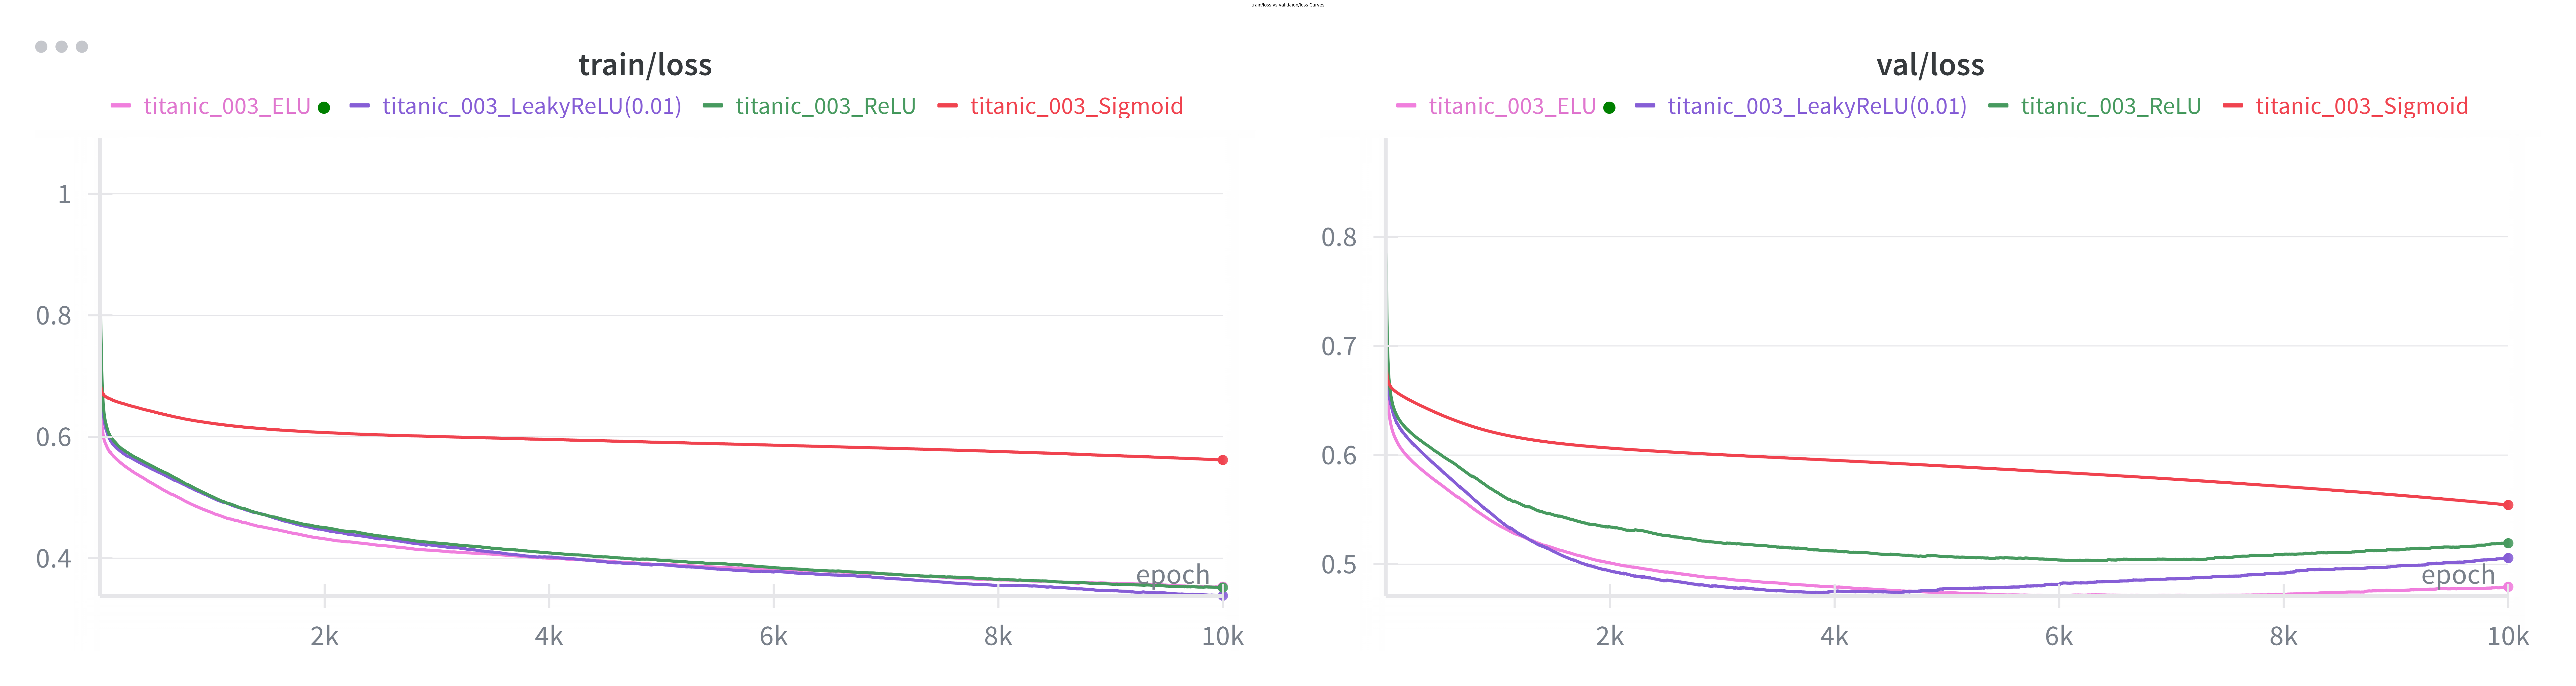

In [13]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

TrainLossAll = cv2.imread('train_loss_All.png')
TrainLossAll = cv2.cvtColor(TrainLossAll, cv2.COLOR_BGR2RGB)
ValidationLossAll = cv2.imread('val_loss_All.png')
ValidationLossAll = cv2.cvtColor(ValidationLossAll, cv2.COLOR_BGR2RGB)

combined = np.hstack((TrainLossAll, ValidationLossAll))

# 시각화
plt.figure(figsize=(128, 64))
plt.imshow(combined)
plt.axis('off')
plt.title('train/loss vs validaion/loss Curves')
plt.show()

## Activation Function(Sigmoid vs. ReLU vs. ELU vs. Leaky ReLU)에 대한 고찰:

**Titanic의 생존자 예측 모델**을 대상으로, 동일한 네트워크 구조와 학습조건에서 활성화 함수만을 변경하며 **Sigmoid, ReLU, ELU, LeakyReLU**의 
성능 차이를 비교하였다. 비교의 기준은 **Validaton Loss와 Train Loss 변화**를 중심으로 분석을 진행하였다.  (epoch:10000, batchsize:512)

---

### Sigmoid()
- Sigmoid 함수는 입력값을 (0,1) 범위로 압축하여 확률적인 해석이 용이하다는 장점이 있다.
- 입력으로 주는 데이터값이 엄청 커지거나 작아질수록 Gradient가 무한히 작아지고 결국 0에 수렴하는 현상이 발생한다(**Vanishing Gradient Problem**).
- 실제 Loss 그래프를 보면 초반 수렴속도가 느리고, layer가 깊어질수록 학습이 거의 진행되지 않아 Loss의 변화가 둔감한 것을 확인할 수 있었다.

  > **결론** : 현재의 Titanic Competition 모델에서는 Sigmoid 함수는 비효율적이다.

---

### ReLU()
- ReLU 함수는 Vanishing Gradient Problem을 해결하기 위해 나온 활성함수이며, x>0 일때 기울기가 1이기 때문에 곱해서 기울기가 작아지는 현상이 발생하지 않는다.
- 입력으로 주는 데이터 값이 음수일 경우 기울기가 0으로 고정되어 일부 뉴런이 활성화 되지 않아 가중치가 새로 업데이트 되지 않는 현상이 발생할 수 있다.(**Dying ReLU** 현상)
- Titanic 실험을 진행하며 ReLU함수는 초반 수렴은 빠르지만, 후반부에 Validation Loss가 상승하는 과적합 양상이 관찰되었다.

  > **결론** : 본 실험 조건에서는 일반적인 성능이 우수하지만 Epoch가 진행될수록 과적합이 되는 양상을 띄었음.

---

### LeakyReLU()
- LeakyReLU 함수는 ReLU 함수가 갖는 Dying ReLU를 해결하기 위해 나온 함수이다.
- x>0이면 x를, x<=0이면 p*x를 반환한다. x에 곱해진 p는 1보다 작은 매우 작은 값이면 무엇이라도 가능하며, 본실험에서는 0.01을 적용하였다.
- Titanic 실험에서는 ReLU 함수와 마찬가지로 Epoch가 진행이 될수록 후반부에는 과적합 징후가 관찰이 되어 약한 OverFitting이 발생한 것으로 추측된다.

  > **결론** : ReLU함수와 마찬가지로 일반적인 성능은 좋으나, 완벽한 안정성을 보이진 않았다.

---

### ELU() (Exponential Linear Unit)
- ELU는 음수 구간에서 출력이 부드럽게(Exponential) 음수로 포화시킨다.
- 이로 인해 **정규화 효과**가 발생하며, Gradient 또한 매끄럽게 유지가 될 수 있다.
- Epoch 초반 다른 Activate Function에 비해 가장 빠른 초기 수렴속도를 보였다.
- Titanic 실험에서는 **가장 낮고 안정적인 Train/Validation Loss**를 확인할 수 있었으며, 과적합 현상도 거의 없다.

 > **결론** : 본 Titanic Competition에서 가장 안정적이고 성능이 우수하다고 판단되는 활성함수이다.

---

## 최종 고찰

> Titanic호 생존자 예측과 같은 비교적 단순한 구조의 2진 분류 문제에서는 **ELU**함수가 가장 안정적이라고 판단하였다.

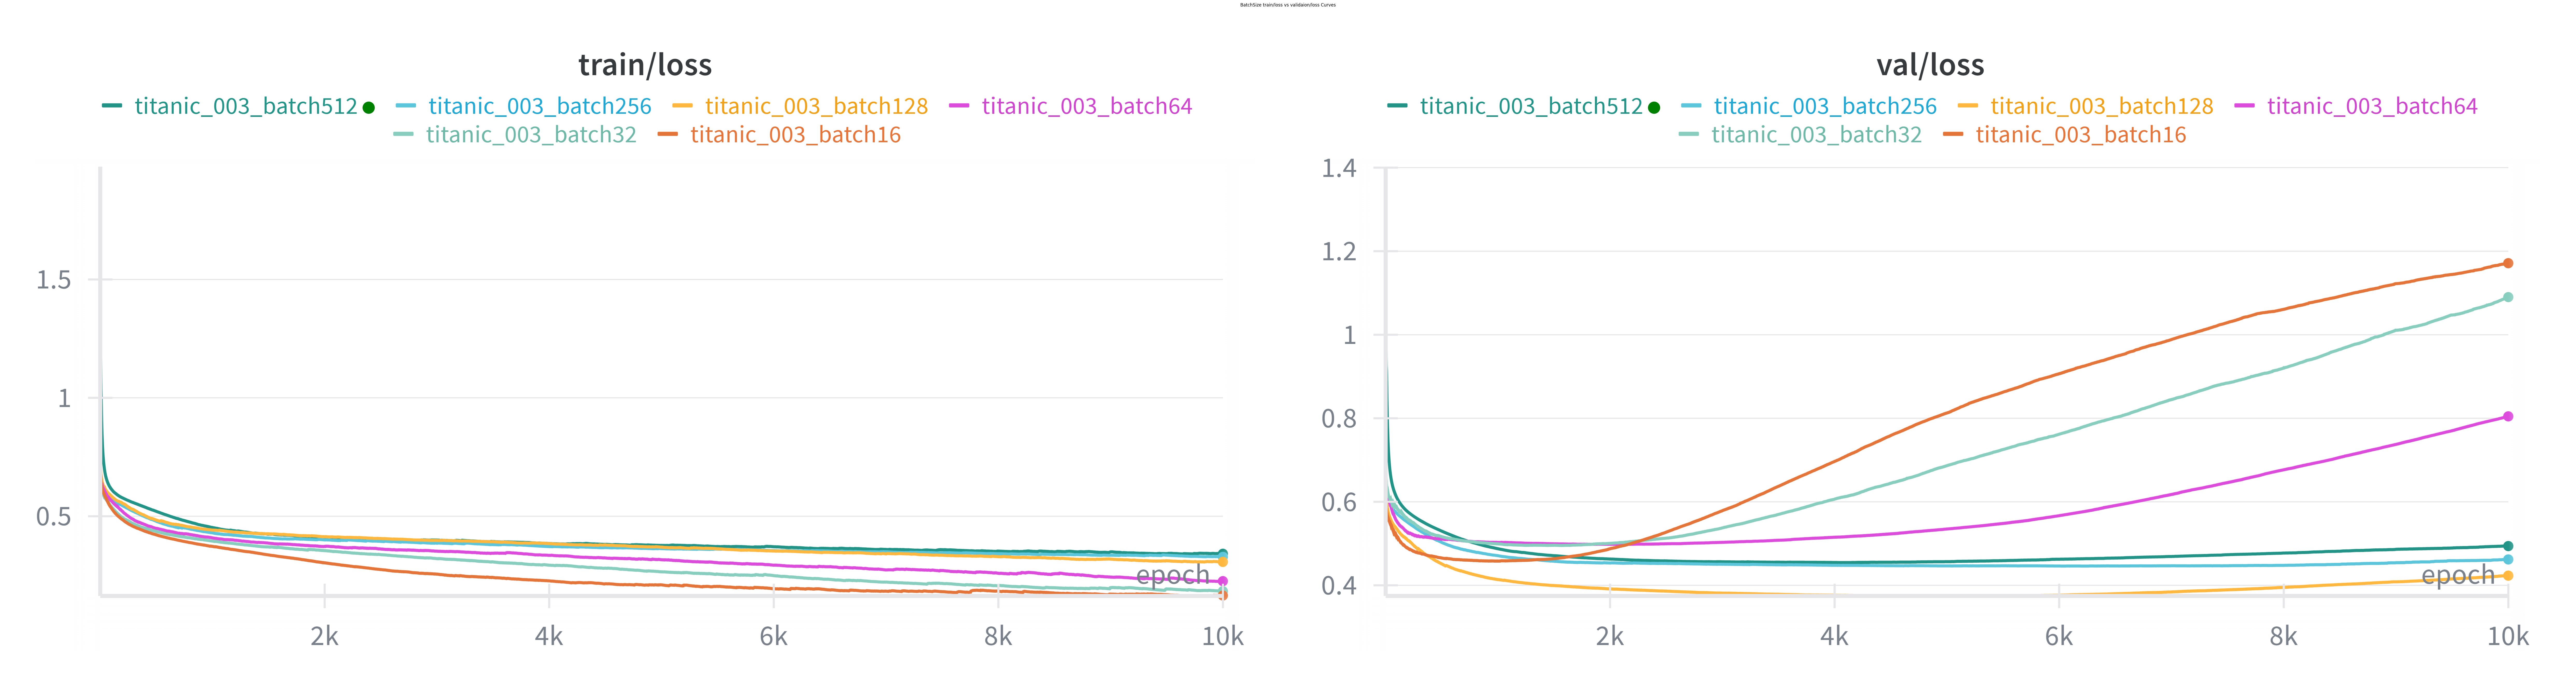

In [18]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

BatchSize_Train_Diff = cv2.imread('BatchSize_train_diff.png')
BatchSize_Train_Diff = cv2.cvtColor(BatchSize_Train_Diff, cv2.COLOR_BGR2RGB)
BatchSize_Validation_Diff = cv2.imread('BatchSize_val_diff.png')
BatchSize_Validation_Diff = cv2.cvtColor(BatchSize_Validation_Diff, cv2.COLOR_BGR2RGB)

combined = np.hstack((BatchSize_Train_Diff, BatchSize_Validation_Diff))

# 시각화
plt.figure(figsize=(128, 64))
plt.imshow(combined)
plt.axis('off')
plt.title('BatchSize train/loss vs validaion/loss Curves')
plt.show()

## Batch Size 변경에 따른 성능 비교 및 고찰

### 실험 개요
Titanic Competition 데이터셋을 대상으로,  
**Batch Size를 16, 32, 64, 128, 256, 512**로 변경하며 학습을 진행하였다.  
모든 조건에서 동일한 네트워크 구조와 Learning Rate를 유지하였으며,  
**Validation Loss**를 기준으로 모델의 일반화 성능을 비교하였다.

---

- **Batch Size 16**  
  - 학습 초반에는 빠르게 수렴했지만, epoch이 진행될수록  
    **train loss는 급격히 감소하고 validation loss는 오히려 상승**하는 과적합(overfitting) 현상이 뚜렷하게 나타났다.  
  - 작은 배치 크기로 인해 모델이 **train 데이터의 패턴과 노이즈까지 과도하게 학습**한 결과로 해석된다.
  - 작은 배치 크기와 Epoch를 줄여서 사용해야 하지만, 그래프에는 없지만 loss의 수치가 잘 떨어지지 않았다.

---

- **Batch Size 32 ~ 64**  
  - 학습 안정성은 개선되었으나, batch 크기가 커질수록 gradient 평균화 효과로 인해  
    세밀한 학습이 어려워졌다.  
  - 또한 Batch Size 16과 마찬가지로 Epoch가 진행이 될수록 Overfitting이 되는것을 확인할 수 있었으며,
  - Loss의 수치가 충분히 내려가지 않았음

---

- **Batch Size 128**  
  - 학습이 가장 안정적으로 진행되었으며, **train과 validation loss 간의 균형이 가장 잘 유지**되었다.  
  - Epoch 5,000~6,000 구간에서 Validation Loss가 더 이상 개선되지 않아  
    **Early Stopping을 적용하면 가장 효율적**일 것으로 판단함.

---

- **Batch Size 256~512**  
  - 학습 속도는 빠르지만, batch가 너무 커지면서 gradient가 지나치게 평균화되어  
    **세밀한 패턴 학습이 부족**하고 validation loss가 일정 수준 이하로 떨어지지 않았다.  
  - 즉, **과소적합(underfitting)** 경향이 나타남.

---

### 결론
> Titanic Competition과 같은 **소규모 데이터셋**에서는  
> **Batch Size 128 + Early Stopping** 설정이  
> 학습 안정성과 일반화 성능 모두에서 가장 우수하다고 볼 수 있다.  

[요구사항 3, 4] 
- 요구사항 1및 기존에 실험으로 찾아본 가장 좋은 성능을 보이는 Activate Func : ELU(), BatchSize : 128을 사용하여 모델을 구성하였음.
- 테스트 데이터(test_data_loader)구성.
- 훈련 과정 중 어느 Epoch 시점에 테스트를 수행하여 submission.csv를 구성해야 하는지 확인하기 > patience를 500으로 설정 후 Early Stop하는 시기를 확인한 결과 Epoch가 1486일때 Early Stop이 동작함.
- Early Stop이 동작한 시점에 모델에 적용된 Weight, Bias를 이용하여 test_data를 수행해보며, 이것의 결과인 submission.csv를 생성.

In [15]:
import sys, os
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import wandb

BASE_PATH = Path(os.getcwd()).resolve().parent
if str(BASE_PATH) not in sys.path:
    sys.path.append(str(BASE_PATH))

from _01_code._99_common_utils.early_stopping import EarlyStopping
from _01_code._99_common_utils.utils import strfdelta

class MyModel(nn.Module):
    def __init__(self, n_input, n_hidden_unit_list, n_output):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_input, n_hidden_unit_list[0]),
            nn.ELU(),
            nn.Linear(n_hidden_unit_list[0], n_hidden_unit_list[1]),
            nn.ELU(),
            nn.Linear(n_hidden_unit_list[1], n_output),
        )
    def forward(self, x):
        return self.model(x)

def get_model_and_optimizer():
    my_model = MyModel(n_input=10, n_hidden_unit_list=[128,64], n_output=2)
    optimizer = optim.SGD(my_model.parameters(), lr=5e-4, momentum=0.9)
    # optimizer = optim.Adam(my_model.parameters(), lr=1e-3)
    return my_model, optimizer

def accuracy_from_logits(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()

def training_loop(
    model,
    optimizer,
    train_data_loader,
    validation_data_loader,
    n_epochs=10000,                      
    checkpoint_file_path="./checkpoints",
    project_name="titanic",
    run_time_str="run1",
    patience=500,                       
    delta=5e-4,
    test_data_loader=None,
    passenger_ids=None
    ):
    os.makedirs(checkpoint_file_path, exist_ok=True)

    loss_fn = nn.CrossEntropyLoss()

    wandb.init(
        project="titanic_competition",
        name="titanic_004",
        config={"optimizer": "SGD","lr": 5e-4,"batch_size": 128,"epochs": n_epochs,"architecture": "MLP(128,64)"}
    )

    early_stopper = EarlyStopping(
        patience=patience,
        delta=delta,
        project_name=project_name,
        checkpoint_file_path=checkpoint_file_path,
        run_time_str=run_time_str
    )

    for epoch in range(1, n_epochs + 1):
        # ---------- Train ----------
        model.train()
        loss_train = 0.0
        acc_train_sum = 0.0
        for batch in train_data_loader:
            x = batch['input'].float()
            y = batch['target'].long()

            logits = model(x)
            loss = loss_fn(logits, y)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
            acc_train_sum += accuracy_from_logits(logits, y)

        # ---------- Validation ----------
        model.eval()
        loss_validation = 0.0
        acc_val_sum = 0.0
        with torch.no_grad():
            for batch in validation_data_loader:
                x = batch['input'].float()
                y = batch['target'].long()
                logits = model(x)
                loss = loss_fn(logits, y)
                loss_validation += loss.item()
                acc_val_sum += accuracy_from_logits(logits, y)

        avg_train_loss = loss_train / max(1, len(train_data_loader))
        avg_val_loss   = loss_validation / max(1, len(validation_data_loader))
        avg_train_acc  = acc_train_sum / max(1, len(train_data_loader))
        avg_val_acc    = acc_val_sum / max(1, len(validation_data_loader))

        print(
            f"Epoch {epoch:05d} | Train {avg_train_loss:.4f}/{avg_train_acc:.3f} | "
            f"Val {avg_val_loss:.4f}/{avg_val_acc:.3f}"
        )

        # --- EarlyStopping
        message, early_stop = early_stopper.check_and_save(avg_val_loss, model)
        print(message)

        if early_stop:
            print(f"Training stopped early at epoch {epoch}")
            break

if __name__ == "__main__":
    train_dataset, validation_dataset, test_dataset = get_preprocessed_dataset()

    print("train_dataset: {0}, validation_dataset: {1}, test_dataset: {2}".format(
        len(train_dataset), len(validation_dataset), len(test_dataset)
    ))
    print("#" * 50, 1)

    train_data_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
    validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=len(validation_dataset))
    test_data_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))

    print("[TRAIN]")
    for idx, batch in enumerate(train_data_loader):
        print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target'].shape))
        break 

    print("[VALIDATION]")
    for idx, batch in enumerate(validation_data_loader):
        print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target'].shape))
        break

    print("[TEST]")
    for idx, batch in enumerate(test_data_loader):
        print("{0} - {1}".format(idx, batch['input'].shape))
        break

    linear_model, optimizer = get_model_and_optimizer()

    print("#"* 50, 2)

    training_loop(
        model=linear_model,
        optimizer=optimizer,
        train_data_loader=train_data_loader,
        validation_data_loader=validation_data_loader,
    )

    print("Done. Check checkpoints/ for saved model files.")


C:\Users\HANNI\AppData\Local\Temp\ipykernel_4620\4164815060.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_df["alone"].fillna(0, inplace=True)
C:\Users\HANNI\AppData\Local\Temp\ipykernel_4620\2801387961.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when

train_X shape: (891, 10)
feature columns: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'honorific', 'family_num', 'alone']
feature count: 10
train_dataset: 713, validation_dataset: 178, test_dataset: 418
################################################## 1
[TRAIN]
0 - torch.Size([128, 10]): torch.Size([128])
[VALIDATION]
0 - torch.Size([178, 10]): torch.Size([178])
[TEST]
0 - torch.Size([418, 10])
################################################## 2


wandb: Currently logged in as: a74930660 (a74930660-korea-university-of-technology-and-education) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 00001 | Train 0.7850/0.689 | Val 0.7247/0.657
Early stopping is stated!
Epoch 00002 | Train 0.6425/0.702 | Val 0.6771/0.607
V_loss decreased (0.72467 --> 0.67708). Saving model...
Epoch 00003 | Train 0.6483/0.671 | Val 0.6387/0.652
V_loss decreased (0.67708 --> 0.63869). Saving model...
Epoch 00004 | Train 0.6109/0.698 | Val 0.6545/0.657
Early stopping counter: 1 out of 500
Epoch 00005 | Train 0.5940/0.716 | Val 0.6453/0.669
Early stopping counter: 2 out of 500
Epoch 00006 | Train 0.5853/0.727 | Val 0.6234/0.674
V_loss decreased (0.63869 --> 0.62338). Saving model...
Epoch 00007 | Train 0.5849/0.709 | Val 0.6196/0.674
V_loss decreased (0.62338 --> 0.61962). Saving model...
Epoch 00008 | Train 0.5812/0.734 | Val 0.6203/0.674
Early stopping counter: 1 out of 500
Epoch 00009 | Train 0.5842/0.721 | Val 0.6331/0.680
Early stopping counter: 2 out of 500
Epoch 00010 | Train 0.5733/0.736 | Val 0.6152/0.663
V_loss decreased (0.61962 --> 0.61518). Saving model...
Epoch 00011 | Train 0.5780

In [56]:
from pathlib import Path
import torch

# 모델 준비
model, _ = get_model_and_optimizer()

# checkpoint 로드 
ckpt_path = Path("./checkpoints/titanic_checkpoint_run1.pt")
model.load_state_dict(torch.load(ckpt_path, map_location="cpu"))
model.eval()
print(f"모델 로드 완료: {ckpt_path.name}")

@torch.no_grad()
def predict_test_logits(model, test_data_loader):
    model.eval()
    outs = []
    for batch in test_data_loader:
        x = batch["input"].float()
        outs.append(model(x))
    return torch.cat(outs, dim=0)

def save_submission_from_logits(logits, passenger_ids, out_csv):
    preds = logits.argmax(dim=1).numpy()
    import pandas as pd
    pd.DataFrame({
        "PassengerId": passenger_ids,
        "Survived": preds
    }).to_csv(out_csv, index=False)
    print(f"Saved submission file: {out_csv}")

# 실행
CURRENT_FILE_PATH = os.path.dirname(os.getcwd())
test_data_path = os.path.join(CURRENT_FILE_PATH, "_04_your_code", "test.csv")
test_df = pd.read_csv(test_data_path)

logits = predict_test_logits(model, test_data_loader)
save_submission_from_logits(logits, test_df["PassengerId"].to_numpy(), "submission.csv")


모델 로드 완료: titanic_checkpoint_run1.pt
Saved submission file: submission.csv


## Kaggle에 업로드한 LeaderBoard
![Kaggle Titanic Leaderboard](https://github.com/BeMyBestFriend/DeepLearning-Practice_Homework/raw/d3ad7ae2460f68f3ce86677a79520e4dca0b40dd/Kaggle_Titanic_Competition_LeaderBoard.png)

[숙제 후기] : 사전 데이터셋의 규모와 Feature에 맞춘 전처리, BatchSize, Epoch, EarlyStop의 중요점을 깨달음.
- 작은 규모의 BatchSize로 무작정 많은 Epoch를 돌리다보면 OverFitting이 일어나는 특징을 Wandb를 통해 시각적으로 한눈에 확인할 수 있던점이 인상깊었음.
- 현재 과제를 진행하며 parser작업은 따로 하지 않았지만 수업시간에 교수님께서 말씀해주신 만큼 앞으로 코드를 구성하면서 parser작업을 이어서 해보고싶음.